# import


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cv2
import pandas as pd


In [2]:
plt.rcParams['figure.figsize'] = [15, 15]

In [3]:
def rescaleData(data, mindata=0, maxdata=1):
	return np.interp(data, (data.min(), data.max()), (mindata, maxdata))

In [4]:
avifile='/media/hydroassist/B0C0-D696/0826/20200826a-ratchet-noise(alter stimulus and periodic chacker)3.avi'

# get background

In [5]:
capture = cv2.VideoCapture(avifile)
backSub = cv2.createBackgroundSubtractorMOG2()

if not capture.isOpened:
    print('Unable to open: ' + file)
    exit(0)
    
totalN = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
imgW = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
imgH = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('width=' , imgW)
print('height=', imgH)
print('length=',totalN)

width= 4096
height= 2168
length= 4140


In [ ]:
cv2.namedWindow("Frame",0);
cv2.resizeWindow("Frame", imgH, imgW);
capture.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = capture.read()
cv2.imshow('Frame', frame)
keyboard = cv2.waitKey(5000)
if keyboard == 'q' or keyboard == 27:
    break
capture.release()  
cv2.destroyAllWindows() 

In [ ]:
cv2.namedWindow("Frame",0);
cv2.resizeWindow("Frame", imgH, imgW);
cv2.namedWindow("background",0);
cv2.resizeWindow("background", imgH, imgW);
# while True:
for j in range(1):
    capture = cv2.VideoCapture(avifile)
    for ID in range(60,1060):
        capture.set(cv2.CAP_PROP_POS_FRAMES, ID)
        ret, frame = capture.read()
        if frame is None:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fgMask = backSub.apply(gray)
        bgimg = backSub.getBackgroundImage()

        
        cv2.rectangle(frame, (10, 2), (300,60), (255,255,255), -1)
        cv2.putText(frame, str(capture.get(cv2.CAP_PROP_POS_FRAMES)), (10, 40), cv2.FONT_HERSHEY_TRIPLEX, 2 , (0,0,0),3)
        cv2.imshow('Frame', frame)
        cv2.imshow('background', bgimg)
#         cv2.imshow('FG Mask', fgMask)


        keyboard = cv2.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break
capture.release()  
cv2.destroyAllWindows() 

In [ ]:
bgfile = avifile[:-4]+'_bg.jpg'
cv2.imwrite(bgfile, bgimg)

In [ ]:
capture.release()
cv2.destroyAllWindows()

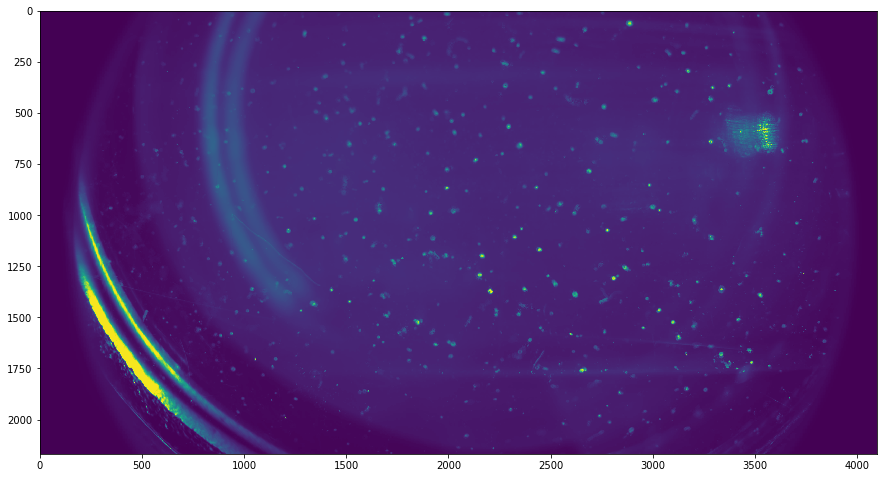

In [6]:
bgfile = avifile[:-4]+'_bg.jpg'
bgimg = cv2.imread(bgfile,cv2.IMREAD_GRAYSCALE)
plt.imshow(bgimg)
plt.show()

In [7]:
imgbg = bgimg.copy()

In [8]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

# detect volvox

In [9]:
cv2.namedWindow("detected circles",0);
cv2.resizeWindow("detected circles", imgH, imgW);

cap = cv2.VideoCapture(avifile)
nframes = totalN 
data=np.array([[0,0,0,0]]) # x,y, radius,frameID
for frameID in range(50,nframes):
    cap.set(1,frameID) # (1, # of frame)
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    imgdiff=gray.astype(float)-imgbg.astype(float)
    imgdiff[np.where(imgdiff<0)]=0
    imgrescale = rescaleData(imgdiff, mindata=0, maxdata=255)
    imgrescale = imgrescale.astype('uint8')
    ret,thimg = cv2.threshold(imgrescale,20,255,cv2.THRESH_BINARY_INV)
    closingimg = cv2.morphologyEx(thimg,cv2.MORPH_CLOSE,kernel)
    closingimg = cv2.morphologyEx(closingimg,cv2.MORPH_CLOSE,kernel)
    circles = cv2.HoughCircles(closingimg,cv2.HOUGH_GRADIENT,1,10,param1=50,param2=10,minRadius=3,maxRadius=20)
    outputimg = frame.copy()

    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(outputimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(outputimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.rectangle(outputimg, (10, 2), (300,60), (255,255,255), -1)
        cv2.putText(outputimg, str(cap.get(cv2.CAP_PROP_POS_FRAMES)), (10, 40), cv2.FONT_HERSHEY_TRIPLEX, 2 , (0,0,0),3)
    cv2.imshow('detected circles',outputimg)
    cv2.waitKey(10)

    tempdata = np.append(circles[0],np.array([[frameID]*circles[0].shape[0]]).T,axis=1)
    data=np.append(data,tempdata,axis=0)
data = np.delete(data,0,0)
dataset = pd.DataFrame({'x':data[:,0],'y':data[:,1],'radius':data[:,2],'frame':data[:,3]})

cap.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# trackpy to create the trajectory

In [10]:
import trackpy as tp

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [11]:
datalink = tp.link_df(dataset, 12, memory=10)

Frame 4139: 624 trajectories present.


In [12]:
filterlink = tp.filter_stubs(datalink, 100)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', datalink['particle'].nunique())
print('After:', filterlink['particle'].nunique())

Before: 789619
After: 2796


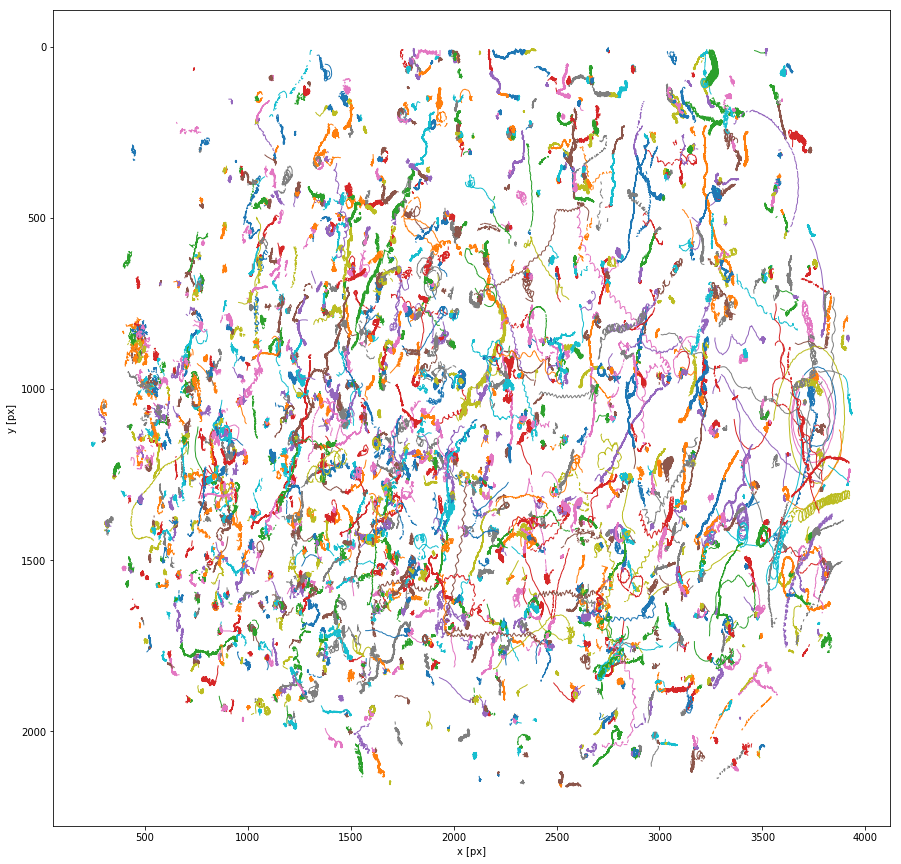

In [13]:
plt.figure(figsize=(15,15))
tp.plot_traj(filterlink, label=False)

# simple analysis

In [14]:
def distance2D(x,y):
	return ((x[1:]-x[0:-1])**2+(y[1:]-y[0:-1])**2)**0.5

def velocity2D(x=[],y=[],t=[]):
	return (((x[1:]-x[0:-1])**2+(y[1:]-y[0:-1])**2)**0.5)/(t[1:]-t[0:-1])

# def GetAngle(v1,v2):
#     v1_theta = math.atan2(v1[1], v1[0])
#     v2_theta = math.atan2(v2[1], v2[0])
#     r = (v2_theta - v1_theta) * (180.0 / math.pi)
#     return r % 360

def GetAngle(vector): 
    return np.arctan2(vector[1], vector[0]) * 180 / np.pi % 360

In [ ]:
filterid = (datalink['particle']==4)
x=datalink[filterid]['x'].values
y=datalink[filterid]['y'].values

plt.plot(x,y)
plt.show()

In [15]:
IDcounts = []
meanR = []
stdR = []
ID = []
travelL = []
speed = []
velocity = []
angles = []
maxmove = []

for vID in pd.unique(filterlink['particle'].values):
    filterid = (filterlink['particle']==vID)
    IDcounts.append(filterlink[filterid].shape[0])
    x=filterlink[filterid]['x'].values
    y=filterlink[filterid]['y'].values
    t=filterlink[filterid]['frame'].values
    r=filterlink[filterid]['radius'].values
    meanR.append(r.mean())
    stdR.append(r.std())
    travelL.append(np.sum(distance2D(x,y)))
    speed.append(np.sum(distance2D(x,y))/(max(t)-min(t)))
    maxmove.append(max((max(x)-min(x)),(max(y)-min(y))))
    velocity.append((((x[-1]-x[0])**2+(y[-1]-y[0])**2)**0.5)/(max(t)-min(t)))
    angles.append(GetAngle([x[-1]-x[0],y[-1]-y[0]]))
    ID.append(vID)
    
trackinfo = pd.DataFrame({'IDcounts':IDcounts,'meanR':meanR,'stdR':stdR,'speed':speed,'velocity':velocity,'travelL':travelL,'maxmove':maxmove,'ID':ID})

In [27]:
trackinfo.head()

ID  IDcounts  maxmove     meanR     speed      stdR      travelL  velocity
0   4       178     29.0  8.628652  2.130758  1.034256   394.190322  0.104396
1   5       116     19.0  9.675862  2.408273  1.224014   329.933408  0.065693
2  14       659     30.0  6.969348  1.730624  1.009951  1330.849491  0.033154
3  15       117     41.0  7.813675  2.164928  1.470793   497.933337  0.105876
4  17       150     90.0  7.633000  3.346011  1.880814   682.586172  0.563064

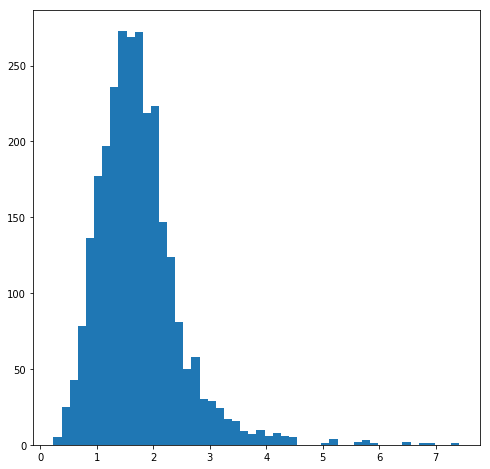

In [35]:
plt.hist(trackinfo.speed.values,bins=50)
plt.show()

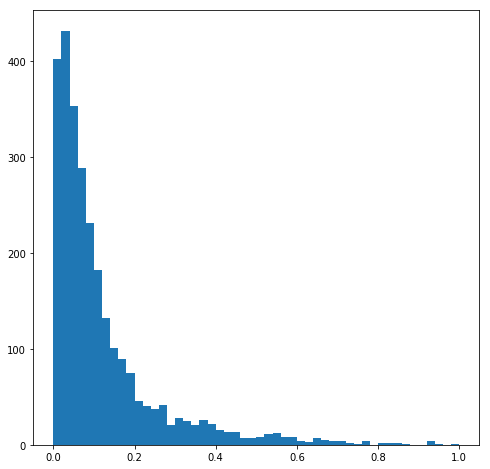

In [37]:
plt.hist(trackinfo.velocity.values,bins=50,range=(0,1))
plt.show()

In [16]:
# %%script false
trackfile=avifile[:-4]+'_track.pkl'
filterfile=avifile[:-4]+'_filtertrack.pkl'
trackinfofile=avifile[:-4]+'_trackinfo.pkl'

datalink.to_pickle(trackfile)
filterlink.to_pickle(filterfile)
trackinfo.to_pickle(trackinfofile)

In [ ]:
filterinfo = trackinfo.loc[(trackinfo['maxmove'] >= 300)].sort_values(by='IDcounts',ascending=False)

In [ ]:
filterinfo.head()

In [ ]:
filterinfo.shape

In [ ]:
imgW = 1600
imgH = 1600

In [ ]:
# %%script false
plt.figure(figsize=(15,15))
for i in filterinfo['ID'].values:
    filterid = (filterlink['particle']==i)
    x=filterlink[filterid]['x'].values
    y=filterlink[filterid]['y'].values
    plt.plot(x,y)
    plt.xlim([0,imgW])
    plt.ylim([0,imgH])
    plt.gca().invert_yaxis()
plt.show()

# load pkl and analysis  
one pixel = xx um  
frame rate = 

In [17]:
plt.rcParams['figure.figsize'] = [8, 8]

In [18]:
import math

In [ ]:
filterfile = avifile[:-4]+'_filtertrack.pkl'

In [ ]:
filterlink = pd.read_pickle(filterfile)

In [19]:
filterlink.head()

frame  radius       x       y  particle
frame                                         
50        50    10.0  3228.5   861.5         4
50        50     9.4  1498.5   438.5         5
50        50     7.1  2647.5  1591.5        14
50        50     7.1  3610.5  1389.5        15
50        50     6.9  1167.5  1898.5        17

In [ ]:
trackinfofile = avifile[:-4]+'_trackinfo.pkl'
trackinfo = pd.read_pickle(trackinfofile)
trackinfo.head()

In [ ]:
trackinfo.loc[trackinfo['ID'] == 682]

## test a partical

In [20]:
filterid = (filterlink['particle']==682)

In [21]:
x=filterlink[filterid]['x'].values
y=filterlink[filterid]['y'].values
t=filterlink[filterid]['frame'].values

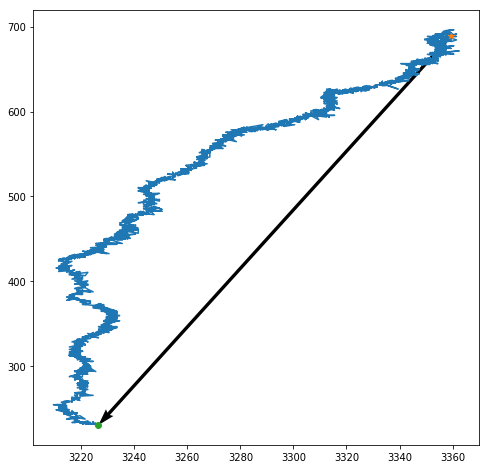

In [22]:
plt.plot(x,y,'-')
plt.quiver([x[0]],[y[0]],[x[-1]-x[0]],[y[-1]-y[0]],angles='xy', scale_units='xy', scale=1)
plt.plot(x[0],y[0],'*')
plt.plot(x[-1],y[-1],'o')
plt.show()

## distance - time graph

In [24]:
from scipy.spatial import distance

### displacement  
x - x[0]

In [25]:
x_reset = x - x[0]
y_reset = y - y[0]
dist_form0 = []
for xt,yt in zip(x_reset,y_reset):
    dist_form0.append(distance.euclidean([xt,yt], [0,0]))

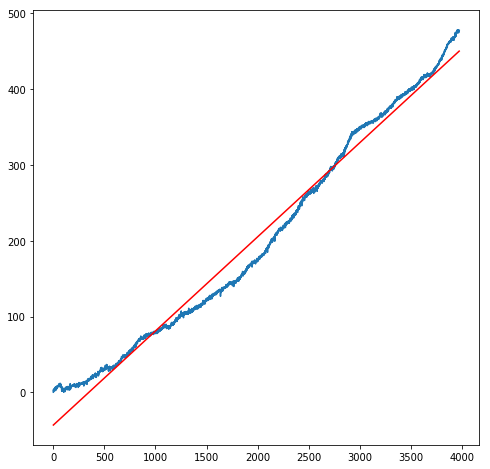

In [26]:
from scipy.optimize import curve_fit

def func_lin(x, a, b):
    return a * x + b


xdata = np.linspace(1, len(dist_form0),len(dist_form0))
popt_lin, pcov_lin = curve_fit(func_lin, xdata, dist_form0)

plt.plot(xdata,dist_form0)
plt.plot(xdata, func_lin(xdata, *popt_lin), 'r-')

plt.show()

### path length  
x[t]-x[t-1]

In [38]:
path = ((x[1:]-x[0:-1])**2+(y[1:]-y[0:-1])**2)**0.5

In [39]:
Integpath = []
temp = 0
for dx in path:
    temp += dx
    Integpath.append(temp)

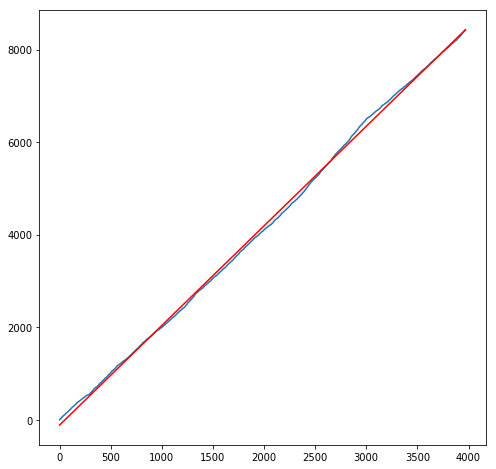

In [40]:
xdata = np.linspace(1, len(Integpath),len(Integpath))
popt_lin, pcov_lin = curve_fit(func_lin, xdata, Integpath)

plt.plot(xdata,Integpath)
plt.plot(xdata, func_lin(xdata, *popt_lin), 'r-')

plt.show()

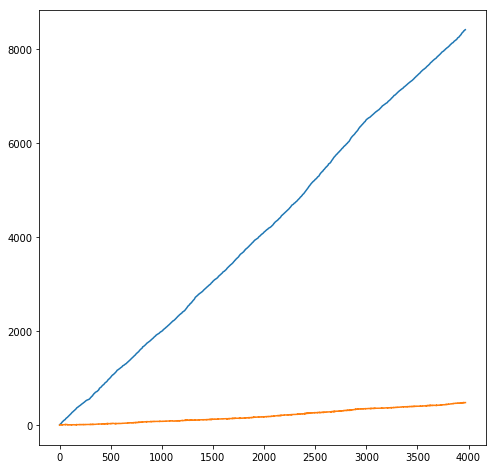

In [41]:
plt.plot(Integpath)
plt.plot(dist_form0)
plt.show()

## angle

In [42]:
# def GetAngle(v1,v2):
#     v1_theta = math.atan2(v1[1], v1[0])
#     v2_theta = math.atan2(v2[1], v2[0])
#     r = (v2_theta - v1_theta) * (180.0 / math.pi)
#     return r % 360

def GetAngle(vector): 
    return np.arctan2(vector[1], vector[0]) * 180 / np.pi %360

In [43]:
GetAngle([x[-1]-x[0],y[-1]-y[0]])

253.84050761533217

In [44]:
trackinfo.head()

ID  IDcounts  maxmove     meanR     speed      stdR      travelL  velocity
0   4       178     29.0  8.628652  2.130758  1.034256   394.190322  0.104396
1   5       116     19.0  9.675862  2.408273  1.224014   329.933408  0.065693
2  14       659     30.0  6.969348  1.730624  1.009951  1330.849491  0.033154
3  15       117     41.0  7.813675  2.164928  1.470793   497.933337  0.105876
4  17       150     90.0  7.633000  3.346011  1.880814   682.586172  0.563064

In [45]:
angles = []
for row in trackinfo['ID']:
    filterid = (filterlink['particle']==row)
    del x,y,t
    x=filterlink[filterid]['x'].values
    y=filterlink[filterid]['y'].values
    t=filterlink[filterid]['frame'].values
    angles.append(GetAngle([x[-1]-x[0],y[-1]-y[0]]))

trackinfo['angles'] = angles

In [46]:
trackinfo.head()

ID  IDcounts  maxmove     meanR     speed      stdR      travelL  velocity  \
0   4       178     29.0  8.628652  2.130758  1.034256   394.190322  0.104396   
1   5       116     19.0  9.675862  2.408273  1.224014   329.933408  0.065693   
2  14       659     30.0  6.969348  1.730624  1.009951  1330.849491  0.033154   
3  15       117     41.0  7.813675  2.164928  1.470793   497.933337  0.105876   
4  17       150     90.0  7.633000  3.346011  1.880814   682.586172  0.563064   

       angles  
0   68.749494  
1   90.000000  
2  221.820170  
3  250.820992  
4  310.763605

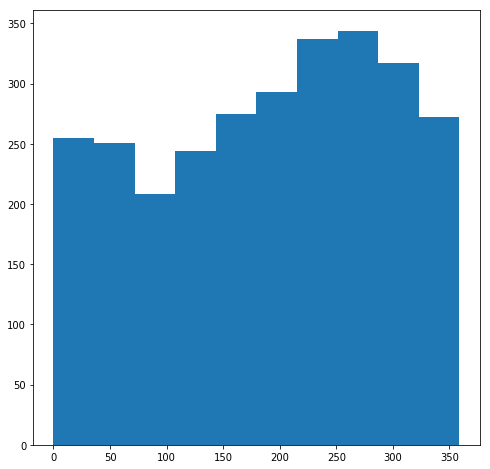

In [47]:
anglehist = plt.hist(trackinfo['angles'].values)
plt.show()

In [48]:
anglehistcount, anglebin_edges = anglehist[0],anglehist[1]

In [49]:
anglebin_center = (anglebin_edges[1:] + anglebin_edges[:-1])/2

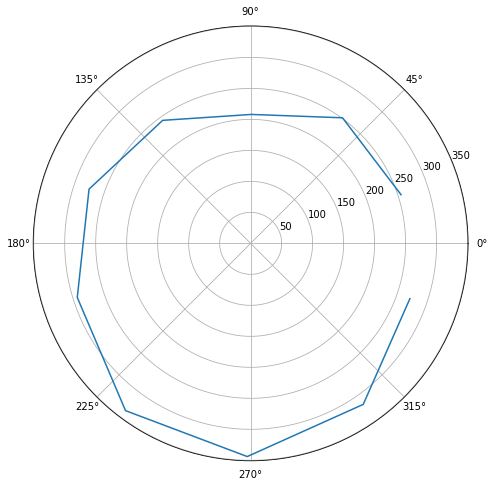

In [50]:
plt.polar(anglebin_center* np.pi / 180.0,anglehistcount)
plt.show()

In [ ]:

for vID in pd.unique(filterlink['particle'].values):
    filterid = (filterlink['particle']==vID)
    IDcounts.append(filterlink[filterid].shape[0])
    x=filterlink[filterid]['x'].values
    y=filterlink[filterid]['y'].values
    t=filterlink[filterid]['frame'].values

    meanR.append(r.mean())
    stdR.append(r.std())
    meanV.append(velocity2D(x=x,y=y,t=t).mean())
    stdV.append(velocity2D(x=x,y=y,t=t).std())
    travelL.append(np.sum(distance2D(x,y)))
    absV.append(np.sum(distance2D(x,y))/(max(t)-min(t)))
    maxmove.append(max((max(x)-min(x)),(max(y)-min(y))))
    ID.append(vID)
    
trackinfo = pd.DataFrame({'IDcounts':IDcounts,'meanR':meanR,'stdR':stdR,'meanV':meanV,'stdV':stdV,'absV':absV,'travelL':travelL,'maxmove':maxmove,'ID':ID})